In [80]:
import yfinance as yfinance
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import timedelta, date
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Setup Values you want to check **Run From here on reruns**

In [81]:
STOCK_TICKER = "AAPL"

TIME_SERIES_LENGTH_TO_TRAIN = timedelta(days=1000)
DAY_TILL_TESTING = date(2020, 1, 1) #Year Month Date


# Instead of doing it like this I should take a times series of 10 days(x values) and try to guess the closing price on the 11th day(y_value)


# Get Historical data from given date trough YFinance

In [82]:
start = DAY_TILL_TESTING - TIME_SERIES_LENGTH_TO_TRAIN
end = DAY_TILL_TESTING - timedelta(days=1)

data = yfinance.download(STOCK_TICKER, start=start, end=end)


[*********************100%***********************]  1 of 1 completed


# Split data into X(input) and Y(output) values and remove useless data

In [83]:
all_values = data.values
closes = data["Close"]["AAPL"].values

X, y = [], []

for i in range(len(all_values) - 10):
    X.append(all_values[i:i+10])
    y.append(closes[i+10])

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train_flat = X_train.reshape(-1, X_train.shape[-1])
X_test_flat = X_test.reshape(-1, X_test.shape[-1])

scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train_flat).reshape(X_train.shape)
X_test_scaled = scaler_X.transform(X_test_flat).reshape(X_test.shape)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# Train Model using Keras

In [84]:
model = keras.Sequential([
    layers.Input(shape=(10, 5)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(1)
])


# Compile with optimizers

In [85]:
model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_6 (Flatten)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,329 (13.00 KB)

 Trainable params: 3,329 (13.00 KB)

 Non-trainable params: 0 (0.00 B)

# Training

In [86]:
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - loss: 0.0476 - mae: 0.1653
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 0.0075 - mae: 0.0659
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - loss: 0.0043 - mae: 0.0494
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 0.0031 - mae: 0.0419
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 0.0026 - mae: 0.0390
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - loss: 0.0024 - mae: 0.0368
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - loss: 0.0020 - mae: 0.0342
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - loss: 0.0019 - mae: 0.0330
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 0.0018 - mae: 0.0318
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - loss: 0.0016 - mae: 0.0304
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - loss: 0.0016 - mae: 0.0298
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - loss: 0.0019 - mae: 0.0328
Epoch 13/50
17/17 ━━━━━━━

# Predict

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


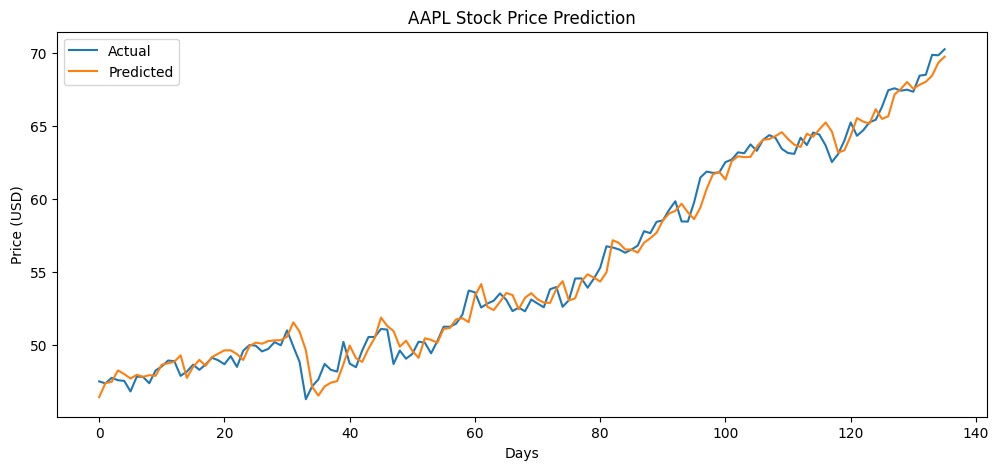

In [87]:
predictions = scaler_y.inverse_transform(model.predict(X_test_scaled))
actual = scaler_y.inverse_transform(y_test_scaled)

plt.figure(figsize=(12, 5))
plt.plot(actual, label="Actual")
plt.plot(predictions, label="Predicted")
plt.title("AAPL Stock Price Prediction")
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()
